# Calculating polymer properties, using built-in analysis methods, and iterating over trajectories

### In this notebook we learn how to use the methods of the atomgroup class to calculate bonds, distances between atoms, angles and dihedrals. We will also calculate typical polymer descriptors such as radius of gyration, end-to-end distance and persistence length. 
### We then see how to iterate over a trajectory, and plot these quantities for each timestep. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import MDAnalysis as mda
from MDAnalysis.lib import distances
import MDAnalysisData as data
import nglview as nv
mda.__version__

'0.19.0'

### 1. Load the dataset

Create a Universe by loading the coordinates of a PEG - poly(ethyleneglycol) chain $HO(CH2CH2)_{20}OH$ 

In [ ]:
polymer = data.datasets.fetch_PEG_1chain()

u = mda.Universe(polymer['topology'], polymer['trajectory'])

In [2]:
u = mda.Universe('tutorial_MDA/PEG.prmtop', 'tutorial_MDA/PEG_03_prod.nc')

In [3]:
u.trajectory

<NCDFReader tutorial_MDA/PEG_03_prod.nc with 50 frames of 13406 atoms>

We loaded a trajectory with 50 frames, but for the first part of this tutorial we'll limit ourselves to look at one frame.

In [4]:
u.trajectory.n_frames

50

Select the polymer (excluding water molecules):

In [12]:
PEG = u.residues[0].atoms

In [13]:
PEG

<AtomGroup with 143 atoms>

### 2. Visualize the system

We can visualize the trajectory using `nglview`, which takes an `atomselection` as input:

In [14]:
poly = nv.show_mdanalysis(PEG)
poly

/anaconda/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:906: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/anaconda/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:906: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/anaconda/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:906: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/anaconda/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:906: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


A Jupyter Widget

### 3. Polymer descriptors

Calculate the center of mass of the polymer chain:

In [15]:
PEG.center_of_mass()

array([22.93376523, 26.82840903, 31.66687739])

Now, calculate the radius of gyration:

In [16]:
PEG.radius_of_gyration()

9.788402668965798

### 4. End-to-end distance of the PEG chain: calc_bonds

We can use the hydrogens in the capping -OH groups (`type ho`) as reference points.
First, select the two hydrogen atoms:

In [17]:
Hb, He = u.atoms.select_atoms("type ho")

Then, calculate the distance between their coordinates:

In [18]:
e2e_dist = np.linalg.norm(Hb.position - He.position)

In [19]:
e2e_dist

26.629349

The numpy function works, but if your system has periodic boundary conditions you want to make sure your distances are calculated using the minimum image convention. We can take care of is by using `distances.calc_bonds`:

In [20]:
distances.calc_bonds(Hb.position, He.position, box=u.dimensions)

26.62934987068575

### 5. Calculate (dihedral) angles: calc_angles & calc_dihedrals
You might need these to check some conformational parameters in your system, or whether your force field yields the expected dihedral angle distribution.

Select the C and O atoms in the PEG chain:

In [124]:
C = u.atoms.select_atoms('type c3 and bonded type os')
O = u.atoms.select_atoms('type os')

Now with some creative index slicing we can look at the C-O-C angles and O-C-C-O dihedrals in our polymer chain.
Since the $CH_{2}$ groups have identical atom types, the simplest way to select only every other carbon is to slice the arrays.

Use `distances.calc_angles` and `distance.calc_dihedrals` to calculate the angles. We will need the positions of the atomgroups involved:

In [22]:
np.rad2deg(distances.calc_angles(C.atoms[::2].positions, O.positions, C.atoms[1::2].positions, box=u.dimensions))

array([112.13267717, 109.14965224, 111.59562312, 115.00692717,
       115.99130492, 111.17841802, 114.22055856, 118.1690136 ,
       107.94286733, 114.26737791, 115.30460132, 111.66299609,
       118.244767  , 113.92092246, 113.0879812 , 112.62143551,
       121.71822062, 120.03081879, 117.2085765 ])

In [23]:
np.rad2deg(distances.calc_dihedrals(O.atoms[:-1].positions, C.atoms[:-2:2].positions, C.atoms[1:-2:2].positions, O.atoms[1:].positions,  box=u.dimensions))

array([ -28.77012048,   44.02457568,  -61.25349936,  -80.66968937,
         42.75184678,   27.3039674 ,  -49.54122278,  -20.06659924,
        -31.02635788,   36.79709104,  -38.34373281,   44.79130445,
       -157.68769315,   45.81115223,   65.46491982,   61.10125031,
        -83.08478549,  -42.69773016])

### 5. Now we do it all again, iterating over the entire trajectory

By default we start at frame 0:

In [63]:
u.trajectory.frame

0

`u.trajectory` can be sliced like a numpy array. 
We can change frame by selecting a different number of the `u.trajectory` object:

In [67]:
u.trajectory[-1]

< Timestep 49 with unit cell dimensions [53.79785  43.960857 57.188725 90.       90.       90.      ] >

We can then iterate through it using a loop. 
Let's calculate $R_g$ and $r_e$ for each frame:

In [114]:
re = []
Rg = []

for ts in u.trajectory:
    re.append(distances.calc_bonds(Hb.position, He.position, box=u.dimensions))
    Rg.append(PEG.atoms.radius_of_gyration())
    

let's calculate the average values $<R_g^2>$ and $<r_e>$:

In [122]:
print(np.mean(re),np.mean([r*r for r in Rg]))

24.739499526094356 106.26052522814936


Now calculate the $O-C-C-O$ dihedrals, like previously, but iterating over the trajectory:

In [165]:
dih=[]
for ts in u.trajectory:
    dih.append(np.rad2deg(distances.calc_dihedrals(O.atoms[:-1].positions,
                                                   C.atoms[:-2:2].positions,
                                                   C.atoms[1:-2:2].positions,
                                                   O.atoms[1:].positions,  
                                                   box=u.dimensions)))

In [166]:
dih

[array([ -28.77012048,   44.02457568,  -61.25349936,  -80.66968937,
          42.75184678,   27.3039674 ,  -49.54122278,  -20.06659924,
         -31.02635788,   36.79709104,  -38.34373281,   44.79130445,
        -157.68769315,   45.81115223,   65.46491982,   61.10125031,
         -83.08478549,  -42.69773016]),
 array([ -57.65955824,   43.19033534,  -20.08218699,  127.91560042,
          39.73973865,  -92.96041763, -156.09164178,  -83.74448872,
         -52.28844   ,   57.63156125,  -54.29321945,  -19.25378068,
        -149.78343684,   51.23886261,   64.56608959,  118.79208064,
          49.25477816, -153.87592896]),
 array([ -60.65668575,   43.3925804 ,  -38.78371114,   48.55575377,
          49.21762522,  139.76119081,  -60.12567824,  -60.38445419,
          29.64230675, -141.66943484,  -32.72480366,  -80.69264449,
         -63.48092423,   86.26773666,   41.41642831,  107.72153789,
          44.43849878,  -37.94781862]),
 array([  55.31130987,   30.36183091,  -29.71470692,   47.905286

Each element of the dihedrals list is an array, so before looking at the distribution we need to "flatten" it. We can do this in one line using `numpy.concatenate`:

In [167]:
dih= np.concatenate(dih)

In [168]:
dih

array([ -28.77012048,   44.02457568,  -61.25349936,  -80.66968937,
         42.75184678,   27.3039674 ,  -49.54122278,  -20.06659924,
        -31.02635788,   36.79709104,  -38.34373281,   44.79130445,
       -157.68769315,   45.81115223,   65.46491982,   61.10125031,
        -83.08478549,  -42.69773016,  -57.65955824,   43.19033534,
        -20.08218699,  127.91560042,   39.73973865,  -92.96041763,
       -156.09164178,  -83.74448872,  -52.28844   ,   57.63156125,
        -54.29321945,  -19.25378068, -149.78343684,   51.23886261,
         64.56608959,  118.79208064,   49.25477816, -153.87592896,
        -60.65668575,   43.3925804 ,  -38.78371114,   48.55575377,
         49.21762522,  139.76119081,  -60.12567824,  -60.38445419,
         29.64230675, -141.66943484,  -32.72480366,  -80.69264449,
        -63.48092423,   86.26773666,   41.41642831,  107.72153789,
         44.43849878,  -37.94781862,   55.31130987,   30.36183091,
        -29.71470692,   47.90528616,   54.93099027,   39.83355

Now plot the histogram:

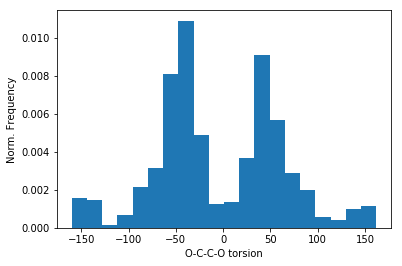

In [169]:
fig, ax = plt.subplots()
ax.hist(dih, bins=20, density=True)
ax.set_xlabel("O-C-C-O torsion")
ax.set_ylabel("Norm. Frequency")

plt.show()

### 6. Persistence length 

This is also a built-in method. In this case, we don't have to iterate over the trajectory because the function already does that for us.

In analysing polymers, the persistence length is a measure of a chains stiffness.  The persistence length is the distance at which the direction of two points on a polymer chain becomes decorrelated.  High persistence lengths indicate that the polymer chain is rigid and doesn't change direction, low persistence lengths indicate that the polymer chain has little memory of its orientation.

The bond autocorrelation function $C(n)$ measures the average cosine of the angle between bond vector $\mathbf{a_i}$ and a bond vector $n$ bonds away. 

$$C(n) = \langle \cos\theta_{i, i+n} \rangle= \langle \mathbf{a_i} \cdot \mathbf{a_{i+n}} \rangle$$

This is then fitted to an exponential decay, where $l_B$ is the average bond length, and $l_P$ is the persistence length.


$$C(n) \approx \exp\left(-\frac{n l_B}{l_P}\right)$$


In [75]:
from MDAnalysis.analysis.polymer import PersistenceLength

Select the backbone of the polymer. It's easy in this case since we only need to exclude hydrogens:

In [76]:
backbone=PEG.atoms.select_atoms('not name H*')

It is important that the contents of the polymer `atomgroup` are in order. 
Selections done using `select_atoms` will always be sorted.
This can be checked by listing the `atomgroup`.

In [77]:
list(backbone[:10])

[<Atom 1: C of type c3 of resname UNL, resid 1 and segid SYSTEM>,
 <Atom 2: C1 of type c3 of resname UNL, resid 1 and segid SYSTEM>,
 <Atom 3: O of type oh of resname UNL, resid 1 and segid SYSTEM>,
 <Atom 8: O1 of type os of resname UNL, resid 1 and segid SYSTEM>,
 <Atom 9: C2 of type c3 of resname UNL, resid 1 and segid SYSTEM>,
 <Atom 11: C3 of type c3 of resname UNL, resid 1 and segid SYSTEM>,
 <Atom 16: O2 of type os of resname UNL, resid 1 and segid SYSTEM>,
 <Atom 17: C4 of type c3 of resname UNL, resid 1 and segid SYSTEM>,
 <Atom 18: C5 of type c3 of resname UNL, resid 1 and segid SYSTEM>,
 <Atom 22: O3 of type os of resname UNL, resid 1 and segid SYSTEM>]

Run the `PersistenceLength` function: 

In [91]:
pl=PersistenceLength([backbone]).run()

We can plot the autocorrelation using pl.results:

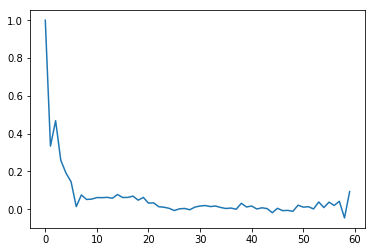

In [92]:
plt.plot(pl.results)
plt.show()

The tool can then perform the exponential decay fit for us, which populates the `.lp` attribute.

We can check the validity of the fit by plotting the results, using the `.plot()` function:

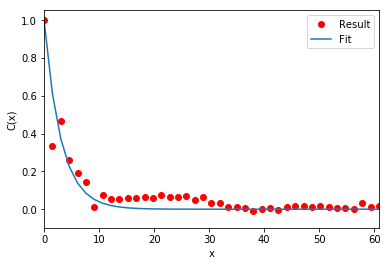

In [100]:
pl.perform_fit()
pl.plot()
plt.show()

.. Or just look at the value of $l_{P}$:

In [101]:
pl.lp

3.07790020530282